In [1]:
import ee
import eemont
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import ipyleaflet
import ipywidgets as widgets

from scipy.signal import savgol_filter
import matplotlib.dates as mdates

import datetime

import geemap

In [2]:
crop_lookup = {'OSR': 'Rapeseed Oil',
               'WW': 'Wheat',
               'WW2': 'Second Wheat',
               'WB': 'Winter Barley',
               'SB': 'Spring Barley',
               'PP': 'Permanent Pasture',
               'MZ': 'Maize',
               'VPEAS': 'Vining Peas',
               'WLIN': 'Winter Linseed',
               'FAL': 'Fallow',
               'POTS': 'Potatoes',
               'PIGS': 'Pigs',
               'LEY': 'Grass Ley',
               'WLIN': 'Winter Linseed',
               'FAL': 'Fallow'
              }

palette = {    
    'AGRO': 'ff0000',
    'IN HAND': '0000FF', 
    'NIAB': '00ff00', 
    'OSR': 'FFFF00', 
    'PIGS': 'ffb6c1', 
    'POTS': 'FFA500', 
    'PP': '006400', 
    'VPEAS': '800080',
    'WB': 'd2b48c', 
    'WW': 'F5DEB3',
    'WW2': '93856b',
    'LEY': 'FFFF99',
    'WLIN': 'b5651d',
    'FAL': 'C19A6B',
    '': 'FFFFFF',
    'UNKNOWN': 'FFFFFF'
}

vis_params = {
    'colorOpacity': .5,
    'width': 2,
    'lineType': 'dotted', 
    'fillColorOpacity': 0.65   
}

In [11]:
class spen_farm():
    def __init__(self):
        self.Map = geemap.Map()
        
        self.aoi = ee.FeatureCollection("users/spiruel/aoi")
        self.aoi_area_s2 = 13480
        self.aoi_area_planet = 7907.351973668423
        self.planet_collection = ee.ImageCollection("users/spiruel/spen_planet_2021")
        self.fields = ee.FeatureCollection("users/spiruel/fields")
        
        self.fields_list = self.fields.toList(100)
        self.field_names = [i['properties']['Field_name'] for i in self.fields_list.getInfo()]
    
        self.init_date = '2021-04-20'
        self.date = datetime.datetime.strptime(self.init_date,'%Y-%m-%d')
        self.sel_date_year = self.date.year
        self.graph_exist = False
        self.download_control = None
        self.selected_fc_geom = None
        self.flower_date = None
        
        self.min_date = datetime.datetime(2017,4,19)
        unix2datetime = lambda x: datetime.datetime.fromtimestamp(x/1E3)
        #today = datetime.datetime.today().strftime('%Y-%m-%d')
        #self.min_planet_date = unix2datetime( self.planet_collection.first().get('system:time_start').getInfo() )
        self.min_planet_date = datetime.datetime(2020, 1, 1, 0, 0)
        #self.max_planet_date = unix2datetime( self.planet_collection.closest(today).first().get('system:time_start').getInfo() )
              
        self.init_layers()
        self.field_dropdown()
        self.date_pick()
        self.desc_box()
        self.plot_button()
        self.crc_control()
        self.Map.on_interaction(self.handle_interaction)
        
    def init_layers(self):
        self.Map.setOptions('SATELLITE')
        
        s2_col = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(self.aoi).closest(self.init_date).maskClouds().index(['NDVI'])
        self.s2 = s2_col.median().clip(self.aoi)
        self.masked_perc_s2 = (self.aoi_area_s2 - self.s2.clip(self.aoi).reduceRegion(
            'count', self.aoi, 20).get('CLOUD_MASK').getInfo())/self.aoi_area_s2
        
        palette_crops = palette.copy()
        current_crops = [i['properties'][f"Y{self.date.year}"] for i in self.fields_list.getInfo()]
        for crop_pal in (set(palette_crops.keys()) - set(current_crops)):
            palette_crops.pop(crop_pal, None)
            
        self.Map.add_styled_vector(self.fields, column=f"Y{self.date.year}", palette=palette_crops, layer_name="fields", **vis_params)
        
        self.planet = self.planet_collection.closest(self.init_date).first()
        self.planet_ndvi = self.planet.normalizedDifference(['b4', 'b3']).rename('NDVI')
        if self.date >= self.min_planet_date:
            self.masked_perc_planet = (self.aoi_area_planet - self.planet.clip(self.aoi).mask().clip(self.aoi).reduceRegion(
                'sum', self.aoi, 20).get('b1').getInfo())/self.aoi_area_planet
        
            self.Map.addLayer(self.planet, {'bands':['b3','b2','b1'],'min':0, 'max':2000}, 'planet')
            self.Map.addLayer(self.planet_ndvi, {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}, 'planet_ndvi')

        self.Map.addLayer(self.s2, {'bands':['B4','B3','B2'], 'min':0, 'max':2000}, 's2')
        self.Map.addLayer(self.s2.normalizedDifference(['B8', 'B4']).rename('NDVI'), {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}, 's2_ndvi')

        self.Map.centerObject(self.fields, 14)
        
    def field_dropdown(self):
        self.dropdown = widgets.Dropdown(
            options=sorted(self.field_names),
            value='Spen Field',
            description='Field:'
        )

        self.dropdown.observe(self.handle_interaction, names='value')
            
        dropdown_output_control = ipyleaflet.WidgetControl(widget=self.dropdown, position='bottomleft')
        self.Map.add_control(dropdown_output_control)
        
    def desc_box(self):
        self.output_widget = widgets.Output(layout={'border': '1px solid black'})
        output_control = ipyleaflet.WidgetControl(widget=self.output_widget, position='bottomright')
        self.Map.add_control(output_control)

    def handle_interaction(self, *args, **kwargs):
        #print(args, kwargs)
        if len(args) > 0:
            self.selected_fc = self.fields.filterMetadata('Field_name', 'equals', args[0]['new'])
        elif kwargs.get('type') == 'click':
            latlon = kwargs.get('coordinates')
            self.Map.default_style = {'cursor': 'wait'}
            xy = ee.Geometry.Point(latlon[::-1])
            self.selected_fc = self.fields.filterBounds(xy)
        elif kwargs.get('type') != 'date_change':
            return

        with self.output_widget:
            self.output_widget.clear_output()

            try:
                self.selected_fc_name = self.selected_fc.first().get('Field_name').getInfo()
                date_str = self.date.strftime('%Y-%m-%d')
                print(f'{date_str}:')
                crop = self.selected_fc.first().get(f'Y{self.date.year}').getInfo()
                if crop in crop_lookup:
                    crop = crop_lookup[crop]

                self.selected_fc_geom = self.selected_fc.geometry()
                layer_desc = self.selected_fc_name + '\n' + crop
                self.Map.addLayer(ee.Image().paint(self.selected_fc_geom, 0, 2), {'palette': 'red'}, 'selected field')  
                print(layer_desc)
                
                print(f'{100*self.masked_perc_s2:.0f}% S2 cloud filtered')
                if self.date >= self.min_planet_date:
                    print(f'{100*self.masked_perc_planet:.0f}% Planet cloud filtered')
                
                if self.dropdown.value != self.selected_fc_name:
                    self.dropdown.value = self.selected_fc_name
            except Exception as e:
                #print(e)
                print('No feature could be found')
                try:
                    self.Map.remove_ee_layer('selected field')
                except Exception as e:
                    pass

        self.Map.default_style = {'cursor': 'pointer'}

    def handle_date_sel(self, *args):
        self.Map.default_style = {'cursor': 'wait'}
        date_str = args[0]['new'].strftime('%Y-%m-%d')
        self.date = datetime.datetime.combine(args[0]['new'], datetime.time())
        if  self.date < self.min_date or  self.date > datetime.datetime.today():
            self.Map.default_style = {'cursor': 'pointer'}
            return
        
        self.handle_crc({'new':False, 'old':None})
        self.toggle_button.value = False

        s2_col = ee.ImageCollection('COPERNICUS/S2_SR').filterBounds(self.aoi).closest(date_str).maskClouds()
        self.s2 = s2_col.median().clip(self.aoi)
        self.masked_perc_s2 = (self.aoi_area_s2 - self.s2.clip(self.aoi).reduceRegion(
            'count', self.aoi, 20).get('CLOUD_MASK').getInfo())/self.aoi_area_s2
        
        self.planet = self.planet_collection.closest(date_str).first()
        self.planet_ndvi = self.planet.normalizedDifference(['b4', 'b3']).rename('NDVI')
        if self.date >= self.min_planet_date:
            self.masked_perc_planet = (self.aoi_area_planet - self.planet.clip(self.aoi).mask().clip(self.aoi).reduceRegion(
                'sum', self.aoi, 20).get('b1').getInfo())/self.aoi_area_planet

        #self.Map.remove_ee_layer('s2')
        #self.Map.remove_ee_layer('s2_ndvi')
        #self.Map.remove_ee_layer('selected field')
        
        palette_crops = palette.copy()
        current_crops = [i['properties'][f"Y{self.date.year}"] for i in self.fields_list.getInfo()]
        for crop_pal in (set(palette_crops.keys()) - set(current_crops)):
            palette_crops.pop(crop_pal, None)
            
        if self.date.year != self.sel_date_year:
            self.Map.add_styled_vector(self.fields, column=f"Y{self.date.year}", palette=palette_crops, layer_name="fields", **vis_params)
            self.sel_date_year = self.date.year
            
        if self.date >= self.min_planet_date:
            self.Map.addLayer(self.planet, {'bands':['b3','b2','b1'],'min':0, 'max':2000}, 'planet')
            self.Map.addLayer(self.planet_ndvi, {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}, 'planet_ndvi')
        
        self.Map.addLayer(self.s2, {'bands':['B4','B3','B2'], 'min':0, 'max':2000}, 's2')
        self.Map.addLayer(self.s2.normalizedDifference(['B8', 'B4']).rename('NDVI'), {min: -1, max: 1, 'palette': ['blue', 'white', 'green']}, 's2_ndvi')

        if self.selected_fc_geom is not None:
            self.Map.addLayer(ee.Image().paint(self.selected_fc_geom, 0, 2), {'palette': 'red'}, 'selected field')

        self.handle_interaction(**{'type':'date_change'})
        self.Map.default_style = {'cursor': 'pointer'}
        
    def date_pick(self):
        date_picker = widgets.DatePicker(
            description='Date',
            disabled=False,
            value=datetime.datetime.strptime(self.init_date,'%Y-%m-%d'),
            layout={'border': '1px solid black'}
        )

        date_picker.observe(self.handle_date_sel, names='value')

        date_output_control = ipyleaflet.WidgetControl(widget=date_picker, position='bottomleft')
        self.Map.add_control(date_output_control)
        
    def plot_button(self):
        plot_button = widgets.Button(
            description='Plot NDVI',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Plot NDVI',
            icon='check' # (FontAwesome names without the `fa-` prefix)
        )

        plot_button.on_click(self.handle_ndvi_plot)

        self.button_output_control = ipyleaflet.WidgetControl(widget=plot_button, position='bottomright')
        self.Map.add_control(self.button_output_control)
        
    def handle_ndvi_plot(self, *args):
        self.Map.default_style = {'cursor': 'wait'}
        
        output_widget = widgets.Output(layout={'border': '1px solid black'})
        output_control = ipyleaflet.WidgetControl(widget=output_widget, position='bottomright')
        self.Map.add_control(output_control)

        with output_widget:
            output_widget.clear_output()
            print('Plotting NDVI...')
            try:
                self.Map.remove_control(self.button_output_control)
            except Exception:
                pass

            try:
                start_date = max(self.min_date,self.date-datetime.timedelta(days=365)).strftime('%Y-%m-%d')
                end_date = self.date.strftime('%Y-%m-%d')
                s2 = (ee.ImageCollection('COPERNICUS/S2_SR').filterDate(start_date,end_date)
                  .filterBounds(self.aoi)
                  .maskClouds()
                  .scale()
                  .index(['NDVI']))
                
                planet = self.planet_collection.filterDate(start_date,end_date).first()
                planet_ndvi = planet.normalizedDifference(['b4', 'b3']).rename('NDVI')
        
                ts = s2.getTimeSeriesByRegion(geometry = self.selected_fc_geom,
                                              bands = ['NDVI'],
                                              reducer = [ee.Reducer.mean(),ee.Reducer.stdDev()],
                                              scale = 20)

                print('Downloading data...')
                df = geemap.ee_to_pandas(ts)
                print('Downloaded data!')

                df.loc[df['NDVI'] < -999] = np.nan

                df.date = pd.to_datetime(df.date)
                df.date = df.date.apply(lambda x: x.replace(minute=0, second=0))

                df.loc[df.reducer=='mean'] = df.loc[df.reducer=='mean'].drop_duplicates('date')
                df.loc[df.reducer=='stdDev'] = df.loc[df.reducer=='stdDev'].drop_duplicates('date')

                df_std = df.loc[df.reducer=='stdDev']
                df_mean = df.loc[df.reducer=='mean']

                mean = df_mean.loc[df_mean.date.isin(df_std.date)].NDVI.values
                std = df_std.NDVI.values
                dates = df_mean.loc[df_mean.date.isin(df_std.date)].date

                def addNDYI(img):
                    nd = img.normalizedDifference(['B3', 'B2']);
                    return img.addBands(nd.float().rename('NDYI'));

                crop = self.selected_fc.first().get(f'Y{self.date.year}').getInfo()
                if crop == 'OSR':
                    april1 = datetime.datetime(self.date.year,4,1)
                    if dates.min() <= april1 and dates.max() >= april1:
                        if any(dates.apply(lambda x: x.month).isin([3,4,5])):
                            #flowering_date = self.get_flowering()
                            print('Calculating flowering...')
                            s2 = s2.map(addNDYI)
                            ts_ndyi = s2.getTimeSeriesByRegion(geometry = self.selected_fc_geom,
                                                  bands = ['NDYI'],
                                                  reducer = [ee.Reducer.mean()],
                                                  scale = 40)

                            df_ndyi = geemap.ee_to_pandas(ts_ndyi)
                            df_ndyi.date = pd.to_datetime(df_ndyi.date)
                            
                            months = df_ndyi.date.apply(lambda x: x.month)
                            mask = (months >= 2) & (months <= 6)
                            df_ndyi = df_ndyi.loc[mask]
                            if len(df_ndyi) > 0:
                                df_ndyi.loc[df_ndyi['NDYI'] < -999] = np.nan
                                df_ndyi.date = df_ndyi.date.apply(lambda x: x.replace(minute=0, second=0))

                                df_ndyi.loc[df_ndyi.reducer=='mean'] = df_ndyi.loc[df_ndyi.reducer=='mean'].drop_duplicates('date')
                                df_mean_ndyi = df_ndyi.loc[df_ndyi.reducer=='mean']

                                self.flower_date = df_mean_ndyi.date.values[np.where(df_mean_ndyi.NDYI == df_mean_ndyi.NDYI.max())[0]][0]
                    else:
                        self.flower_date = None
                else:
                    self.flower_date = None

                def estimate_gaussian(dataset):

                    mu = np.mean(dataset)
                    sigma = np.std(dataset)
                    limit = sigma * 2

                    min_threshold = mu - limit
                    max_threshold = mu + limit

                    return mu, sigma, min_threshold, max_threshold

                mu, sigma, min_threshold, max_threshold = estimate_gaussian(mean)

                condition1 = (mean < min_threshold)
                condition2 = (mean > max_threshold)

                mask = ~(condition1 | condition2)
                dates = np.array(dates)[mask]
                mean = np.array(mean)[mask]
                std = np.array(std)[mask]

                fig = plt.figure(figsize=(6,3))

                plt.plot(dates, mean, '.-', label='mean')
                plt.fill_between(dates, mean-std, mean+std, alpha=.25)

                # apply SavGol filter
                if len(mean) > 9:
                    mean_savgol = savgol_filter(mean, window_length=9, polyorder=2)
                    plt.plot(dates, mean_savgol, label='savitsky-golay')

                if self.flower_date is not None:
                    plt.axvline(self.flower_date, alpha=.5, c='red', ls='--', label='est. flowering')

                plt.title(self.selected_fc_name)
                plt.ylim(0,1)
                plt.ylabel('NDVI')
                plt.grid(linestyle='dashed')
                plt.legend()

                ax = plt.gca()
                locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
                formatter = mdates.DateFormatter('%Y-%m-%d')
                ax.xaxis.set_major_locator(locator)
                ax.xaxis.set_major_formatter(formatter)

                # Create an output widget to host the plot
                if self.graph_exist:
                    with self.output_graph_widget:
                        self.output_graph_widget.clear_output()
                        self.Map.remove_control(self.output_graph_control)
                else:
                    self.output_graph_widget = widgets.Output()

                # Show the plot on the widget
                with self.output_graph_widget:
                    self.output_graph_widget.clear_output()
                    plt.show()
                    self.graph_exist = True
                
                if self.download_control is not None:
                    self.Map.remove_control(self.download_control)
                
                df_download = pd.DataFrame()
                df_download['date'] = dates
                df_download['mean'] = mean
                df_download['std'] = std
                df_download['mean_savgol'] = mean_savgol
                df_download.to_csv('download.csv', index=False)
                url = geemap.create_download_link('download.csv').data.replace(
                    'Click here to download:  download.csv','Download plot data')
                self.url = url
                download = widgets.HTML(
                    value=url,
                )
                self.download_control = ipyleaflet.WidgetControl(widget=download, position="bottomright")
                self.Map.add_control(self.download_control)

                print('done!')
                # Add the widget as a control to the map
                self.output_graph_control = ipyleaflet.WidgetControl(widget=self.output_graph_widget, position="bottomright")
                self.Map.add_control(self.output_graph_control)
            except Exception as e:
                print('Error! Could not plot.')
                #raise Exception(e)
                if self.graph_exist:
                    with self.output_graph_widget:
                        self.output_graph_widget.clear_output()
                        self.Map.remove_control(self.output_graph_control)
                
            output_widget.clear_output()

            self.Map.add_control(self.button_output_control)
            
            self.Map.default_style = {'cursor': 'pointer'}
            
    def handle_crc(self, args):
        if type(args['old']) == dict:
            if 'value' in args['old'].keys():
                if args['old']['value']:
                    B2 = self.s2.select('B2')
                    B4 = self.s2.select('B4')
                    B12 = self.s2.select('B12')

                    crc = 100*(B2 - B4)/(B2 - B12)

                    vis_params_crc = {
                      'min': 0,
                      'max': 100,
                      'palette': ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725']}

                    self.Map.addLayer(crc, vis_params_crc, 'Crop Residue Cover')

                    if self.Map.colorbar is not None:
                        try:
                            self.Map.remove_colorbar()
                        except:
                            pass
                    self.Map.add_colorbar(vis_params_crc)
            
        elif not args['new']:
            if self.Map.colorbar is not None:
                try:
                    self.Map.remove_colorbar()
                    self.Map.remove_ee_layer('Crop Residue Cover')
                except:
                    pass

    def crc_control(self):
        self.toggle_button = widgets.ToggleButton(
            value=False,
            description='Show CRC',
            disabled=False,
            button_style='', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Crop Residue Cover',
            icon='check' # (FontAwesome names without the `fa-` prefix)
        )

        self.toggle_button.observe(self.handle_crc)
        
        toggle_control = ipyleaflet.WidgetControl(widget=self.toggle_button, position='bottomright')
        self.Map.add_control(toggle_control)

In [12]:
interface = spen_farm()
m = interface.Map
m.layout.width = '100%'
m.layout.height = '800px'
m

Map(center=[53.866630114908745, -1.3284900402892075], controls=(ZoomControl(options=['position', 'zoom_in_text…

In [94]:
df1 = pd.read_csv('download (1).csv', usecols=['date', 'mean', 'std', 'mean_savgol'])
df2 = pd.read_csv('download (2).csv', usecols=['date', 'mean', 'std', 'mean_savgol'])
df3 = pd.read_csv('download (3).csv', usecols=['date', 'mean', 'std', 'mean_savgol'])
df = pd.read_csv('download.csv', usecols=['date', 'mean', 'std', 'mean_savgol'])

In [95]:
df = pd.concat([df, df1, df2, df3])
df.date = pd.to_datetime(df.date)
df.date = df.date.apply(lambda x: x.replace(minute=0, second=0))
df = df.sort_values('date')
df = df.drop_duplicates('date')

2018-03-15 00:00:00
WW
2019-03-15 00:00:00
POTS
2020-03-14 00:00:00
WW
2021-03-14 00:00:00
WB


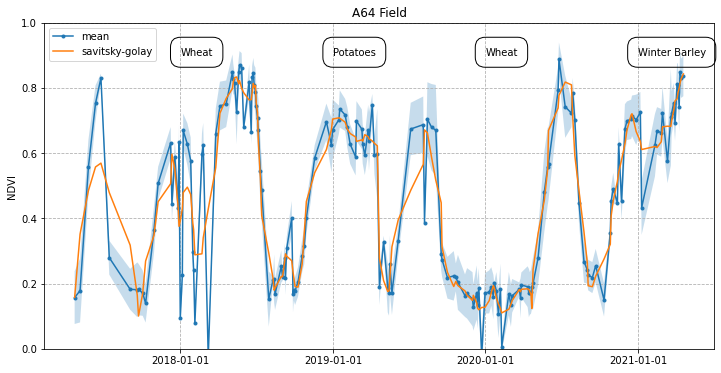

In [132]:
plt.figure(figsize=(12,6))


plt.plot(df['date'], df['mean'], '.-', label='mean')
plt.fill_between(df['date'], df['mean']-df['std'], df['mean']+df['std'], alpha=.25)

plt.plot(df['date'], df['mean_savgol'], label='savitsky-golay')
                    
plt.title(interface.selected_fc_name)
plt.ylim(0,1)
plt.ylabel('NDVI')
plt.grid(linestyle='dashed')
plt.legend(loc=2)
                
ax = plt.gca()
locator = mdates.AutoDateLocator(minticks=3, maxticks=5)
formatter = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

for i in range(len(crops)):
    print(datetime.datetime(2018,3,15)+datetime.timedelta(days=365)*i)
    print(crops[i])
    plt.text(x = datetime.datetime(2018,1,1)+datetime.timedelta(days=365)*i, y=0.9, s=crop_lookup[crops[i]], bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=1'))
    
plt.savefig('ndvi.pdf', dpi=300, bbox_inches='tight')